In [17]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

sns.set(style="whitegrid")

ARTIFACTS_DIR = Path("artifacts")
DATA_DIR = Path(".")

# Nihai (tuned) GBR modelini yükle
model = load(ARTIFACTS_DIR / "gbr_model.joblib")

# Test verisini yükle
X_test = np.load(DATA_DIR / "X_test_processed.npy")
y_test = np.load(DATA_DIR / "y_test.npy").reshape(-1)

# Tahminler
y_pred_test = model.predict(X_test)

len(y_test), len(y_pred_test)


(2503, 2503)

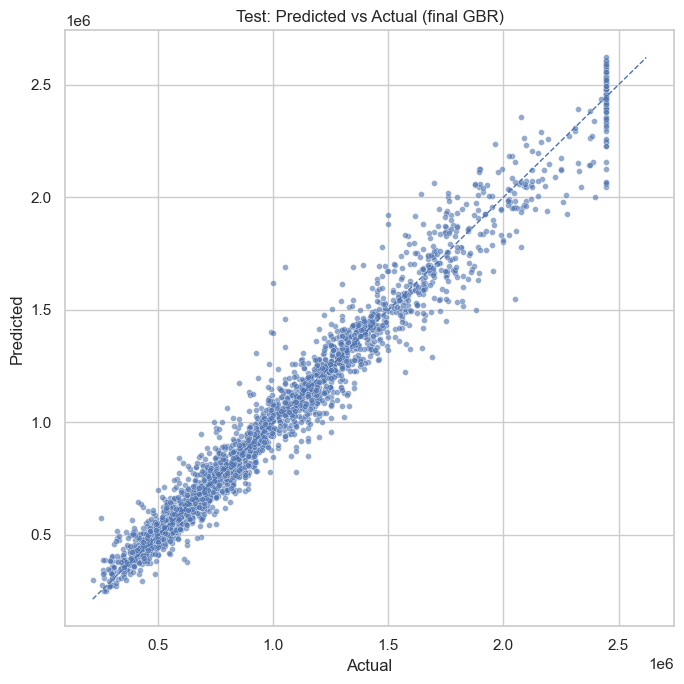

In [18]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred_test, s=18, alpha=0.6)

lo = float(min(y_test.min(), y_pred_test.min()))
hi = float(max(y_test.max(), y_pred_test.max()))
plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test: Predicted vs Actual (final GBR)")
plt.tight_layout()

# İstersen aynı dosyayı tekrar kaydedebilirsin:
# plt.savefig(ARTIFACTS_DIR / "pred_vs_actual_test.png", dpi=160)

plt.show()


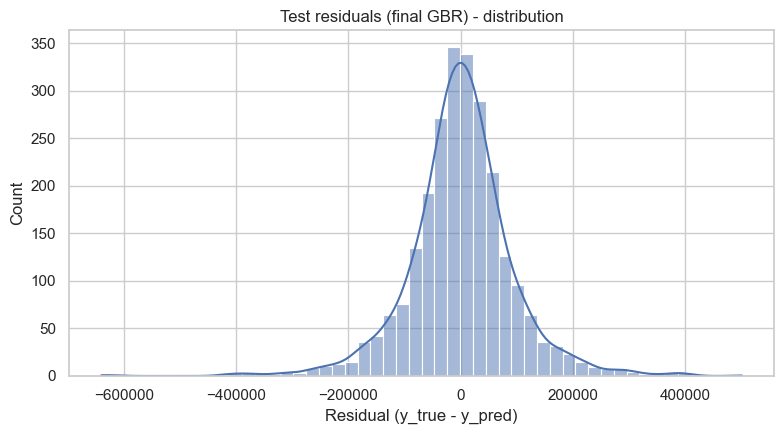

In [19]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 4.5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Test residuals (final GBR) - distribution")
plt.xlabel("Residual (y_true - y_pred)")
plt.tight_layout()

# Kaydetmek istersen:
# plt.savefig(ARTIFACTS_DIR / "residuals_test_hist.png", dpi=160)

plt.show()


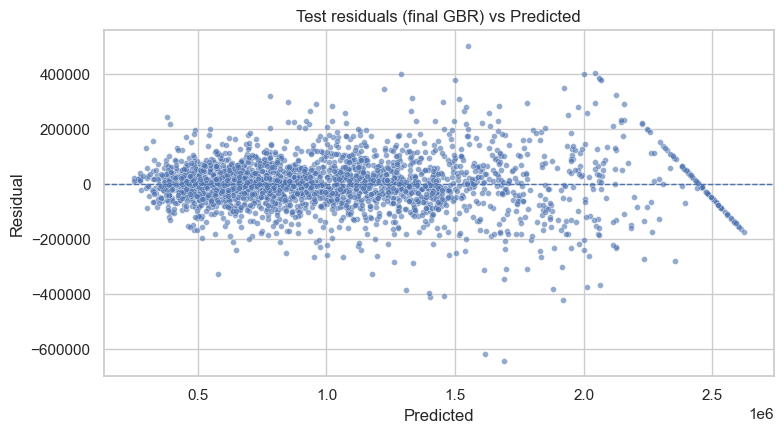

In [20]:
plt.figure(figsize=(8, 4.5))
sns.scatterplot(x=y_pred_test, y=residuals, s=18, alpha=0.6)
plt.axhline(0.0, linestyle="--", linewidth=1)

plt.title("Test residuals (final GBR) vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.tight_layout()

# Kaydetmek istersen:
# plt.savefig(ARTIFACTS_DIR / "residuals_test_vs_pred.png", dpi=160)

plt.show()


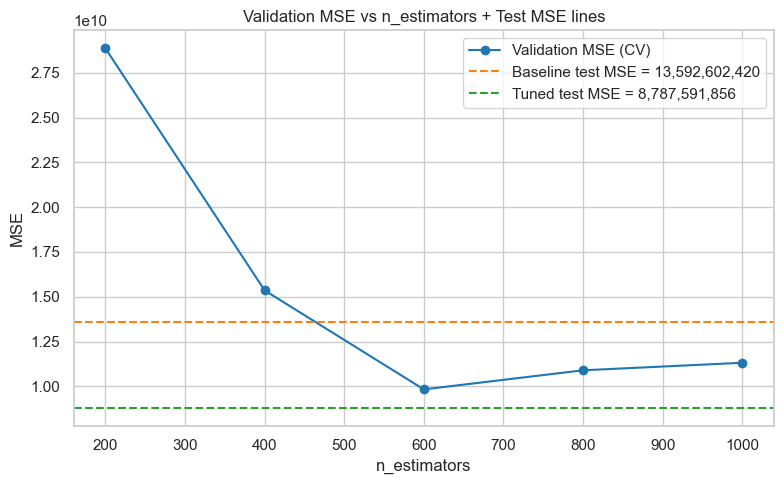

In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt

cv_df = pd.read_csv("artifacts/gbr_cv_results.csv")
grouped = cv_df.groupby("param_regressor__n_estimators")["mean_val_mse"].mean().reset_index()

with open("artifacts/metrics_and_params.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

baseline_mse = meta["baseline"]["test_metrics"]["mse"]
tuned_mse = meta["tuned"]["test_metrics"]["mse"]

plt.figure(figsize=(8, 5))

# Validation eğrisi: mavi
plt.plot(
    grouped["param_regressor__n_estimators"],
    grouped["mean_val_mse"],
    marker="o",
    color="tab:blue",
    label="Validation MSE (CV)",
)

# Baseline test: turuncu kesikli
plt.axhline(
    baseline_mse,
    linestyle="--",
    color="tab:orange",
    label=f"Baseline test MSE = {baseline_mse:,.0f}",
)

# Tuned test: yeşil kesikli
plt.axhline(
    tuned_mse,
    linestyle="--",
    color="tab:green",
    label=f"Tuned test MSE = {tuned_mse:,.0f}",
)

plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("Validation MSE vs n_estimators + Test MSE lines")
plt.legend()
plt.tight_layout()
plt.show()


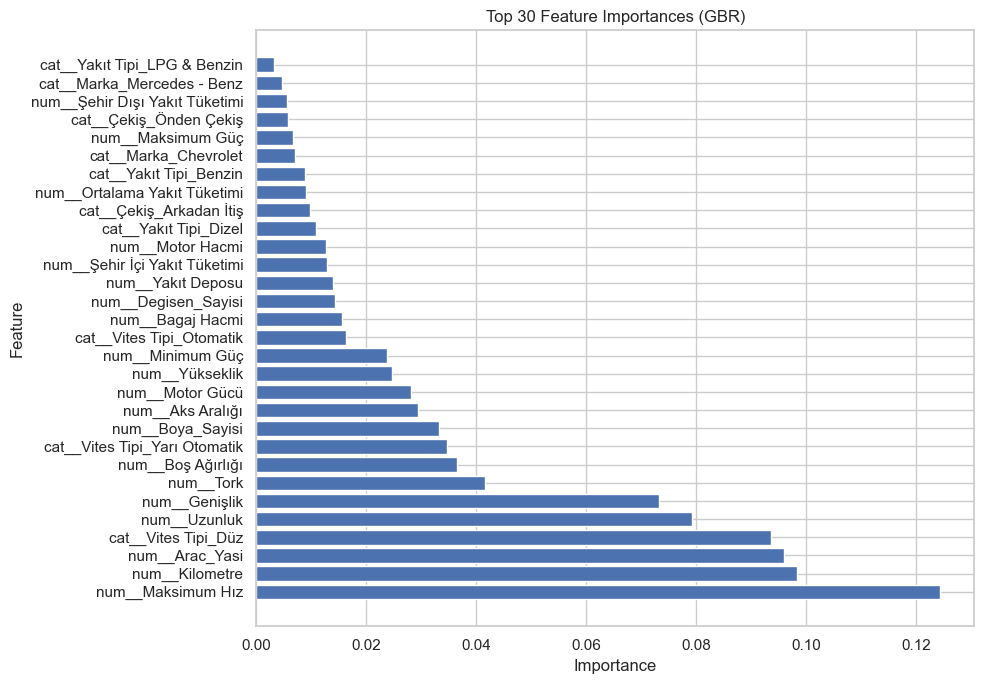

In [22]:
df_imp = pd.read_csv(ARTIFACTS_DIR / "feature_importance.csv")

# 1) En önemli 30 feature'ı seç (importance DESC)
top30 = df_imp.sort_values("importance", ascending=False).head(30)

# 2) Bu 30'un kendi içinde importance'a göre ARTAN sıraya sok
topk = top30.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(topk["feature"], topk["importance"])
plt.title("Top 30 Feature Importances (GBR)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

# İstersen PNG olarak da kaydedebilirsin:
# plt.savefig(ARTIFACTS_DIR / "feature_importance_top30.png", dpi=160)

plt.show()
